# Ajuste de datos experimentales a osciladores

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

## Lectura de datos exportados de tracker

In [2]:
# Definimos una función para leer los datos de un txt de tiempo, posición, velocidad y aceleración
# quitando la ultima columna, normalizando el tiempo entre 0 y 1, convirtiendo de m a cm,
# iniciando la posición en 0
def leer_datos(nombre_pelota):
    ruta = "../Tracking/tablas_datos/Datos_" + nombre_pelota + ".txt"
    datos = pd.read_csv(ruta, sep = "\t", skiprows=1, decimal=",")
    datos.drop(datos.columns[len(datos.columns)-1], axis=1, inplace=True)
    datos["t"] = datos["t"] - datos["t"].min()
    # datos["t"] = (datos["t"] - datos["t"].min()) / (datos["t"].max() - datos["t"].min())
    for columna in datos.columns[1:]:
        datos[columna] = datos[columna] * 100
    datos["x"] = datos["x"] - datos["x"].min()
    return datos

In [5]:
# Leemos los datos de goma, pingpong, plastGrand y pingpong_2D
datos_goma = leer_datos("goma")
datos_pingpong = leer_datos("pingpong")
datos_plastGrand = leer_datos("plastGrand")
datos_pingpong_2D = leer_datos("pingpong_2D")

# Eliminar ultimos datos de goma
datos_goma.drop(datos_goma.index[-2:], inplace = True)

# Corrección para la de pingpong
for columna in datos_pingpong.columns[1:]:
    datos_pingpong[columna] = datos_pingpong[columna] * 1e29

# Centrar las oscilaciones
datos_pingpong["x"] = datos_pingpong["x"] - datos_pingpong["x"].mean()

# Centrar las oscilaciones amortiguadas
datos_goma["x"] = datos_goma["x"] - datos_goma["x"].iloc[-1]
datos_plastGrand["x"] = datos_plastGrand["x"] - datos_plastGrand["x"].iloc[-1]


In [5]:
# datos_goma.head(4)
datos_pingpong.head(4)
# datos_plastGrand.head(4)
# datos_pingpong_2D.head(4)

,t,x,vx,ax
0,0.000,0.807264,NaN,NaN
1,0.033,0.387264,-13.330,NaN
2,0.067,-0.082736,-12.150,94.42
3,0.100,-0.422736,-6.886,243.20


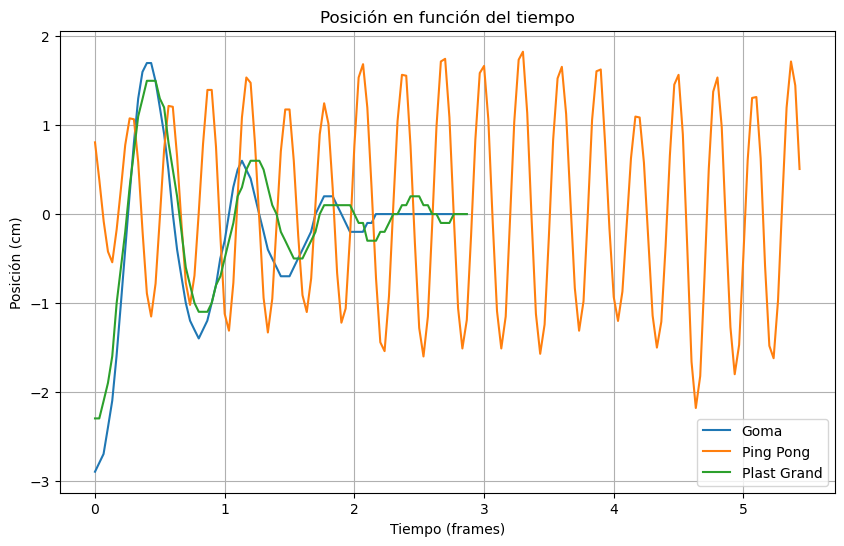

In [15]:
# Graficamos la posición en función del tiempo de las 3 pelotas 1D
plt.figure(figsize=(10,6))
plt.plot(datos_goma["t"], datos_goma["x"], label="Goma")
tam = len(datos_pingpong["t"])
plt.plot(datos_pingpong["t"][:tam//2], datos_pingpong["x"][:tam//2], label="Ping Pong")
plt.plot(datos_plastGrand["t"], datos_plastGrand["x"], label="Plast Grand")
# plt.xticks(np.arange(0, datos_pingpong["t"].max()+1, 1))
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (cm)")
plt.title("Posición en función del tiempo")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Graficamos la velocidad en función del tiempo de las 3 pelotas 1D
plt.figure(figsize=(10,6))
plt.plot(datos_goma["t"], datos_goma["vx"], label="Goma")
plt.plot(datos_pingpong["t"], datos_pingpong["vx"], label="Ping Pong")
plt.plot(datos_plastGrand["t"], datos_plastGrand["vx"], label="Plast Grand")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (cm/s)")
plt.title("Velocidad en función del tiempo")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Graficamos la aceleración en función del tiempo de las 3 pelotas 1D
plt.figure(figsize=(10,6))
plt.plot(datos_goma["t"], datos_goma["ax"], label="Goma")
plt.plot(datos_pingpong["t"], datos_pingpong["ax"], label="Ping Pong")
plt.plot(datos_plastGrand["t"], datos_plastGrand["ax"], label="Plast Grand")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (cm/s²)")
plt.title("Aceleración en función del tiempo")
plt.legend()
plt.grid()
plt.show()

## Selección de modelos

In [46]:
# Definimos las funciones de ajuste
def oscilacion(t, A, w, phi):
    return A*1e-2 * np.cos(w * t + phi)

def oscilacion_amortiguada(t, A, w, phi, gamma):
    return A * np.exp(-gamma * t) * np.cos(w * t + phi)

# Ajustamos los datos de la pelota de goma usando curve_fit
popt_goma, pcov_goma = curve_fit(oscilacion_amortiguada, datos_goma["t"], datos_goma["x"], p0=[3, 2*np.pi*1.25, 0, 1])

# Ajustamos los datos de la pelota de pingpong usando curve_fit
# popt_pingpong, pcov_pingpong = curve_fit(oscilacion, datos_pingpong["t"], datos_pingpong["x"], p0=[1, 2*np.pi*3.5, 0])
popt_pingpong, pcov_pingpong = curve_fit(oscilacion_amortiguada, datos_pingpong["t"], datos_pingpong["x"], p0=[1, 2*np.pi*3.5, 0, 0.01])

# Ajustamos los datos de la pelota de plastGrand usando curve_fit
popt_plastGrand, pcov_plastGrand = curve_fit(oscilacion_amortiguada, datos_plastGrand["t"], datos_plastGrand["x"], p0=[2.5, 2*np.pi*1.25, 0, 1])

# Imprimimos los parámetros de ajuste de las 3 pelotas
print("Pelota de goma:", end="\n")
print("A =", round(popt_goma[0], 3), "+-", round(np.sqrt(pcov_goma[0,0]), 3), "w =", round(popt_goma[1], 3), "+-", round(np.sqrt(pcov_goma[1,1]), 3), "phi =", round(popt_goma[2], 3), "+-", round(np.sqrt(pcov_goma[2,2]), 3), "gamma =", round(popt_goma[3], 3), "+-", round(np.sqrt(pcov_goma[3,3]), 3), end="\n\n")
print("Pelota de pingpong:", end="\n")
# print("A =", round(popt_pingpong[0]*1e-2, 3), "+-", round(np.sqrt(pcov_pingpong[0,0])*1e-2, 3), "w =", round(popt_pingpong[1], 3), "+-", round(np.sqrt(pcov_pingpong[1,1]), 3), "phi =", round(popt_pingpong[2], 3), "+-", round(np.sqrt(pcov_pingpong[2,2]), 3), "f = ", round(popt_pingpong[1]/(2*np.pi), 3), "+-", round(np.sqrt(pcov_pingpong[1,1])/(2*np.pi), 3), end="\n\n")
print("A =", round(popt_pingpong[0], 3), "+-", round(np.sqrt(pcov_pingpong[0,0]), 3), "w =", round(popt_pingpong[1], 3), "+-", round(np.sqrt(pcov_pingpong[1,1]), 3), "phi =", round(popt_pingpong[2], 3), "+-", round(np.sqrt(pcov_pingpong[2,2]), 3), "gamma =", round(popt_pingpong[3], 3), "+-", round(np.sqrt(pcov_pingpong[3,3]), 3), end="\n\n")
print("Pelota de plastGrand:", end="\n")
print("A =", round(popt_plastGrand[0], 3), "+-", round(np.sqrt(pcov_plastGrand[0,0]), 3), "w =", round(popt_plastGrand[1], 3), "+-", round(np.sqrt(pcov_plastGrand[1,1]), 3), "phi =", round(popt_plastGrand[2], 3), "+-", round(np.sqrt(pcov_plastGrand[2,2]), 3), "gamma =", round(popt_plastGrand[3], 3), "+-", round(np.sqrt(pcov_plastGrand[3,3]), 3), end="\n\n")


Pelota de goma:
A = -3.092 +- 0.107 w = 8.692 +- 0.083 phi = -0.592 +- 0.047 gamma = 1.315 +- 0.071

Pelota de pingpong:
A = 1.317 +- 0.045 w = 21.068 +- 0.005 phi = 0.082 +- 0.035 gamma = -0.02 +- 0.005

Pelota de plastGrand:
A = -2.495 +- 0.087 w = 8.024 +- 0.077 phi = -0.416 +- 0.047 gamma = 1.203 +- 0.066



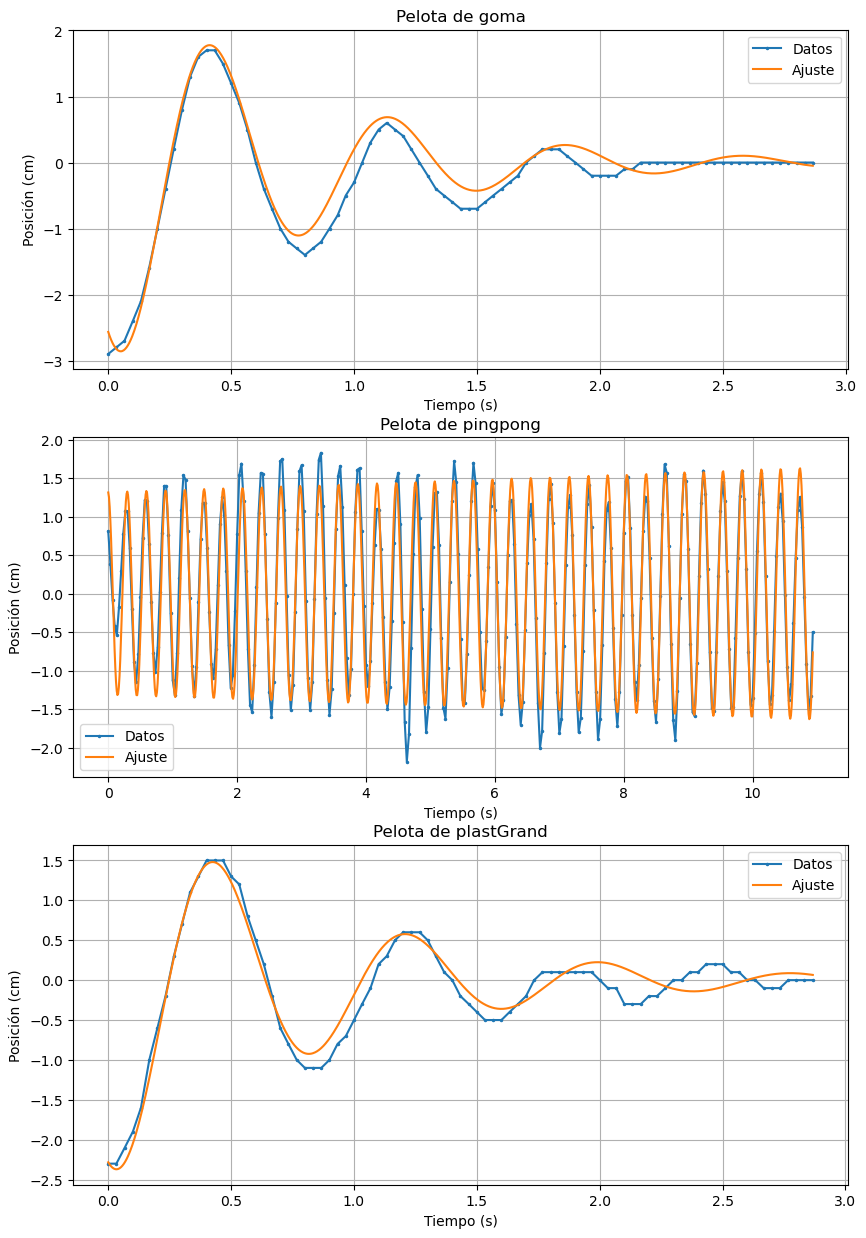

In [47]:
# Graficamos los datos y los ajustes de las 3 pelotas en 3 subplots diferentes
fig, axs = plt.subplots(3, 1, figsize=(10,15))
axs[0].plot(datos_goma["t"], datos_goma["x"], ".-", label="Datos", markersize=3)
# axs[0].plot(datos_goma["t"], oscilacion_amortiguada(datos_goma["t"], *popt_goma), label="Ajuste")
axs[0].plot(np.linspace(0, datos_goma["t"].max(), 1000), oscilacion_amortiguada(np.linspace(0, datos_goma["t"].max(), 1000), *popt_goma), label="Ajuste")
axs[0].set_title("Pelota de goma")
axs[0].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Posición (cm)")
axs[0].legend()
axs[0].grid()

axs[1].plot(datos_pingpong["t"], datos_pingpong["x"], ".-", label="Datos", markersize=3)
# axs[1].plot(datos_pingpong["t"], oscilacion(datos_pingpong["t"], *popt_pingpong), label="Ajuste")
axs[1].plot(np.linspace(0, datos_pingpong["t"].max(), 1000), oscilacion_amortiguada(np.linspace(0, datos_pingpong["t"].max(), 1000), *popt_pingpong), label="Ajuste")
axs[1].set_title("Pelota de pingpong")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Posición (cm)")
axs[1].legend()
axs[1].grid()

axs[2].plot(datos_plastGrand["t"], datos_plastGrand["x"], ".-", label="Datos", markersize=3)
# axs[2].plot(datos_plastGrand["t"], oscilacion_amortiguada(datos_plastGrand["t"], *popt_plastGrand), label="Ajuste")
axs[2].plot(np.linspace(0, datos_plastGrand["t"].max(), 1000), oscilacion_amortiguada(np.linspace(0, datos_plastGrand["t"].max(), 1000), *popt_plastGrand), label="Ajuste")
axs[2].set_title("Pelota de plastGrand")
axs[2].set_xlabel("Tiempo (s)")
axs[2].set_ylabel("Posición (cm)")
axs[2].legend()
axs[2].grid()

plt.show()

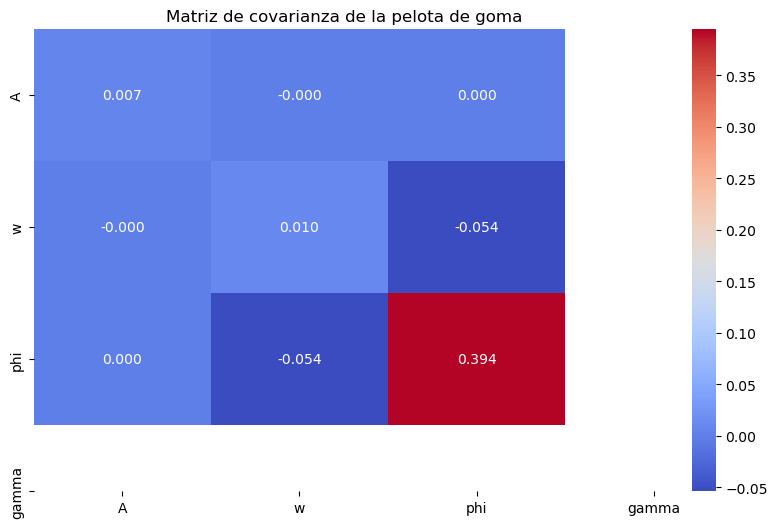

In [56]:
# matriz de covarianza de pingpong marplotlib con labels
plt.figure(figsize=(10,6))
sns.heatmap(pcov_pingpong, annot=True, fmt=".3f", cmap="coolwarm")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["A", "w", "phi", "gamma"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["A", "w", "phi", "gamma"])
plt.title("Matriz de covarianza de la pelota de goma")
plt.show()

# Ajuste de datos discriminando el material (tres esferas de icopor de diferentes tamaños)

## Importamos los datos

In [9]:
# Leemos datos de icopor 1, 2 y 3; pequeño, mediano y grande respectivamente
datos_icopor_peque = leer_datos("icopor1")
datos_icopor_med = leer_datos("icopor2")
datos_icopor_grande = leer_datos("icopor3")

# Centramos las oscilaciones de 1 y 2
datos_icopor_peque["x"] = datos_icopor_peque["x"] - datos_icopor_peque["x"].mean()
datos_icopor_med["x"] = datos_icopor_med["x"] - datos_icopor_med["x"].mean()

# Centramos la oscilacion amortiguada de 3
datos_icopor_grande["x"] = datos_icopor_grande["x"] - datos_icopor_grande["x"].iloc[-1]

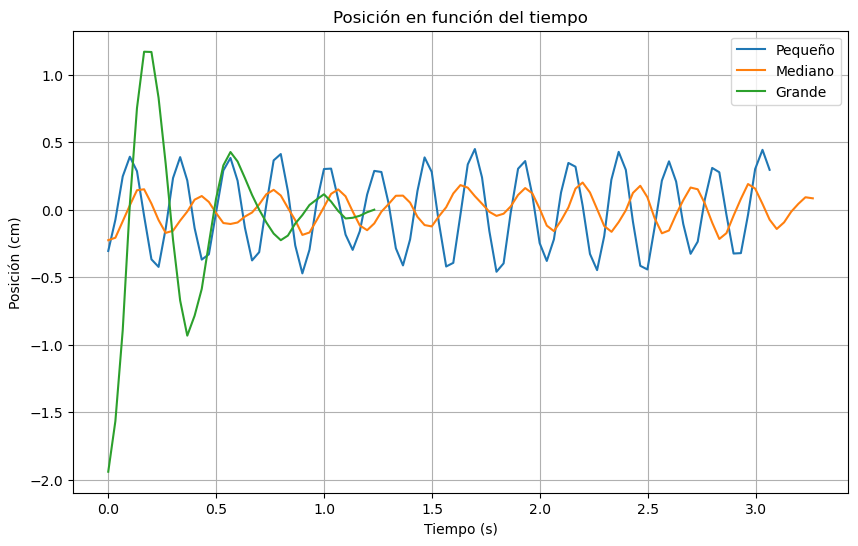

In [17]:
# Graficamos los datos de las 3 pelotas de icopor en función del tiempo
plt.figure(figsize=(10,6))
plt.plot(datos_icopor_peque["t"], datos_icopor_peque["x"], label="Pequeño")
plt.plot(datos_icopor_med["t"], datos_icopor_med["x"], label="Mediano")
plt.plot(datos_icopor_grande["t"], datos_icopor_grande["x"], label="Grande")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (cm)")
plt.title("Posición en función del tiempo")
plt.legend()
plt.grid()
plt.show()

## Selección de modelos

In [42]:
# Ajustamos los datos de la pelota de icopor pequeño usando curve_fit
# popt_icopor_peque, pcov_icopor_peque = curve_fit(oscilacion, datos_icopor_peque["t"], datos_icopor_peque["x"], p0=[0.5, 2*np.pi*4.5, 0])
popt_icopor_peque, pcov_icopor_peque = curve_fit(oscilacion_amortiguada, datos_icopor_peque["t"], datos_icopor_peque["x"], p0=[0.1, 2*np.pi*4.5, 0, 0.01])

# Ajustamos los datos de la pelota de icopor mediano usando curve_fit
# popt_icopor_med, pcov_icopor_med = curve_fit(oscilacion, datos_icopor_med["t"], datos_icopor_med["x"], p0=[0.5, 2*np.pi*3.5, 0])
popt_icopor_med, pcov_icopor_med = curve_fit(oscilacion_amortiguada, datos_icopor_med["t"], datos_icopor_med["x"], p0=[0.5, 2*np.pi*3.5, 0, 0.01])

# Ajustamos los datos de la pelota de icopor grande usando curve_fit
popt_icopor_grande, pcov_icopor_grande = curve_fit(oscilacion_amortiguada, datos_icopor_grande["t"], datos_icopor_grande["x"], p0=[2, 2*np.pi*2.5, 0, 0.1])

# Imprimimos los parámetros de ajuste de las 3 pelotas de icopor
print("Pelota de icopor pequeño:", end="\n")
# print("A =", round(popt_icopor_peque[0]*1e-2, 3), "+-", round(np.sqrt(pcov_icopor_peque[0,0])*1e-2, 3), "w =", round(popt_icopor_peque[1], 3), "+-", round(np.sqrt(pcov_icopor_peque[1,1]), 3), "phi =", round(popt_icopor_peque[2], 3), "+-", round(np.sqrt(pcov_icopor_peque[2,2]), 3), "f = ", round(popt_icopor_peque[1]/(2*np.pi), 3), "+-", round(np.sqrt(pcov_icopor_peque[1,1])/(2*np.pi), 3), end="\n\n")
print("A =", round(popt_icopor_peque[0], 3), "+-", round(np.sqrt(pcov_icopor_peque[0,0]), 3), "w =", round(popt_icopor_peque[1], 3), "+-", round(np.sqrt(pcov_icopor_peque[1,1]), 3), "phi =", round(popt_icopor_peque[2], 3), "+-", round(np.sqrt(pcov_icopor_peque[2,2]), 3), "gamma =", round(popt_icopor_peque[3], 3), "+-", round(np.sqrt(pcov_icopor_peque[3,3]), 3), end="\n\n")
print("Pelota de icopor mediano:", end="\n")
# print("A =", round(popt_icopor_med[0]*1e-2, 3), "+-", round(np.sqrt(pcov_icopor_med[0,0])*1e-2, 3), "w =", round(popt_icopor_med[1], 3), "+-", round(np.sqrt(pcov_icopor_med[1,1]), 3), "phi =", round(popt_icopor_med[2], 3), "+-", round(np.sqrt(pcov_icopor_med[2,2]), 3), "f = ", round(popt_icopor_med[1]/(2*np.pi), 3), "+-", round(np.sqrt(pcov_icopor_med[1,1])/(2*np.pi), 3), end="\n\n")
print("A =", round(popt_icopor_med[0], 3), "+-", round(np.sqrt(pcov_icopor_med[0,0]), 3), "w =", round(popt_icopor_med[1], 3), "+-", round(np.sqrt(pcov_icopor_med[1,1]), 3), "phi =", round(popt_icopor_med[2], 3), "+-", round(np.sqrt(pcov_icopor_med[2,2]), 3), "gamma =", round(popt_icopor_med[3], 3), "+-", round(np.sqrt(pcov_icopor_med[3,3]), 3), end="\n\n")
print("Pelota de icopor grande:", end="\n")
print("A =", round(popt_icopor_grande[0], 3), "+-", round(np.sqrt(pcov_icopor_grande[0,0]), 3), "w =", round(popt_icopor_grande[1], 3), "+-", round(np.sqrt(pcov_icopor_grande[1,1]), 3), "phi =", round(popt_icopor_grande[2], 3), "+-", round(np.sqrt(pcov_icopor_grande[2,2]), 3), "gamma =", round(popt_icopor_grande[3], 3), "+-", round(np.sqrt(pcov_icopor_grande[3,3]), 3), end="\n\n")

Pelota de icopor pequeño:
A = 0.391 +- 0.019 w = 27.86 +- 0.028 phi = 3.193 +- 0.05 gamma = 0.001 +- 0.027

Pelota de icopor mediano:
A = -0.114 +- 0.022 w = 22.228 +- 0.104 phi = -1.012 +- 0.197 gamma = 0.001 +- 0.105

Pelota de icopor grande:
A = -2.014 +- 0.056 w = 16.075 +- 0.131 phi = 0.011 +- 0.036 gamma = 2.616 +- 0.113



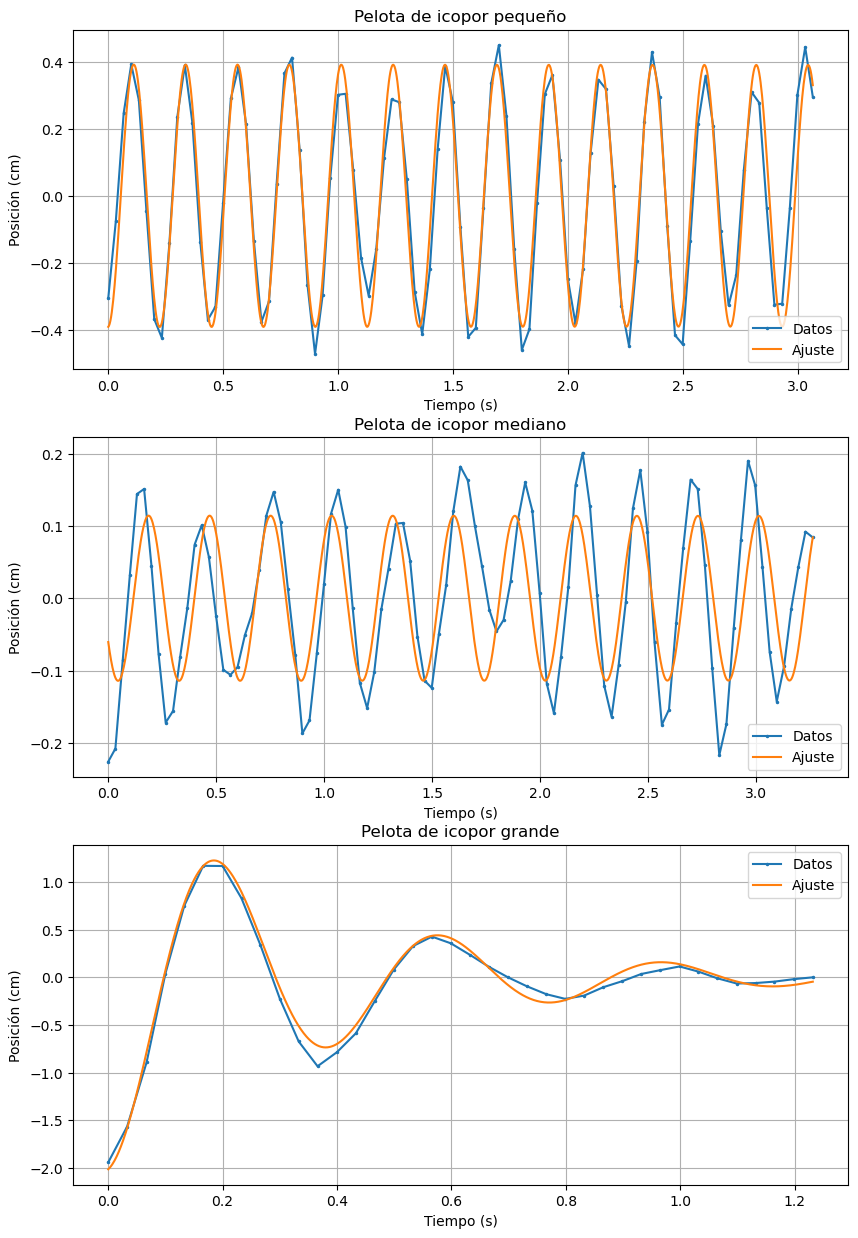

In [41]:
# Graficamos los datos y los ajustes de las 3 pelotas de icopor en 3 subplots diferentes
fig, axs = plt.subplots(3, 1, figsize=(10,15))
axs[0].plot(datos_icopor_peque["t"], datos_icopor_peque["x"], ".-", label="Datos", markersize=3)
# axs[0].plot(datos_icopor_peque["t"], oscilacion(datos_icopor_peque["t"], *popt_icopor_peque), label="Ajuste")
axs[0].plot(np.linspace(0, datos_icopor_peque["t"].max(), 1000), oscilacion_amortiguada(np.linspace(0, datos_icopor_peque["t"].max(), 1000), *popt_icopor_peque), label="Ajuste")
axs[0].set_title("Pelota de icopor pequeño")
axs[0].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Posición (cm)")
axs[0].legend()
axs[0].grid()

axs[1].plot(datos_icopor_med["t"], datos_icopor_med["x"], ".-", label="Datos", markersize=3)
# axs[1].plot(datos_icopor_med["t"], oscilacion(datos_icopor_med["t"], *popt_icopor_med), label="Ajuste")
axs[1].plot(np.linspace(0, datos_icopor_med["t"].max(), 1000), oscilacion_amortiguada(np.linspace(0, datos_icopor_med["t"].max(), 1000), *popt_icopor_med), label="Ajuste")
axs[1].set_title("Pelota de icopor mediano")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Posición (cm)")
axs[1].legend()
axs[1].grid()

axs[2].plot(datos_icopor_grande["t"], datos_icopor_grande["x"], ".-", label="Datos", markersize=3)
# axs[2].plot(datos_icopor_grande["t"], oscilacion_amortiguada(datos_icopor_grande["t"], *popt_icopor_grande), label="Ajuste")
axs[2].plot(np.linspace(0, datos_icopor_grande["t"].max(), 1000), oscilacion_amortiguada(np.linspace(0, datos_icopor_grande["t"].max(), 1000), *popt_icopor_grande), label="Ajuste")
axs[2].set_title("Pelota de icopor grande")
axs[2].set_xlabel("Tiempo (s)")
axs[2].set_ylabel("Posición (cm)")
axs[2].legend()
axs[2].grid()

plt.show()

# Análisis del amortiguamiento en función del tamaño

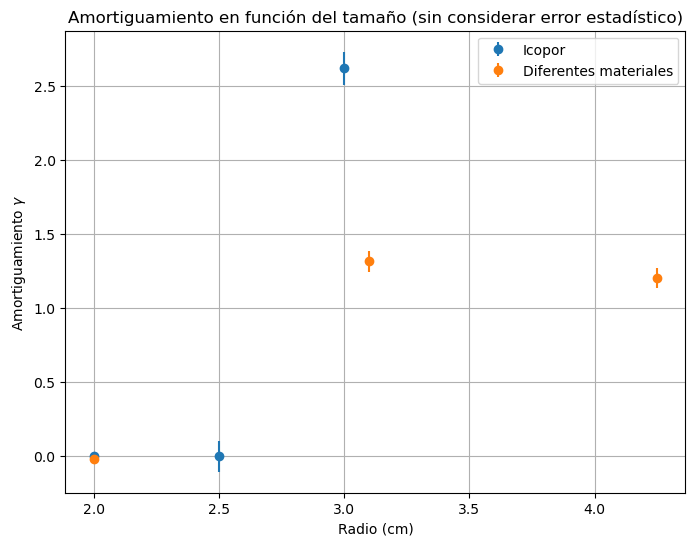

In [66]:
# Obtenemos los amortiguamientos de los ajustes de las 3 pelotas de icopor
gamma_icopor = [popt_icopor_peque[3], popt_icopor_med[3], popt_icopor_grande[3]]
gamma_icopor_error = [np.sqrt(pcov_icopor_peque[3,3]), np.sqrt(pcov_icopor_med[3,3]), np.sqrt(pcov_icopor_grande[3,3])]

# Obtenemos los amortiguamientos de los ajustes de las 3 pelotas de diferentes materiales
gamma = [popt_goma[3], popt_pingpong[3], popt_plastGrand[3]]
gamma_error = [np.sqrt(pcov_goma[3,3]), np.sqrt(pcov_pingpong[3,3]), np.sqrt(pcov_plastGrand[3,3])]

# Obtenemos los tamaños de las 3 pelotas de icopor
tam_icopor = [2, 2.5, 3]

# Obtenemos los tamaños de las 3 pelotas de diferentes materiales
tam = [3.1, 2, 4.25]

# Graficamos el amortiguamiento en función del tamaño de todas las pelotas, diferenciando por material con el error
plt.figure(figsize=(8,6))
plt.errorbar(tam_icopor, gamma_icopor, yerr=gamma_icopor_error, fmt="o", label="Icopor")
plt.errorbar(tam, gamma, yerr=gamma_error, fmt="o", label="Diferentes materiales")
plt.xlabel("Radio (cm)")
plt.ylabel("Amortiguamiento $\gamma$")
plt.title("Amortiguamiento en función del tamaño (sin considerar error estadístico)")
plt.legend()
plt.grid()
plt.show()

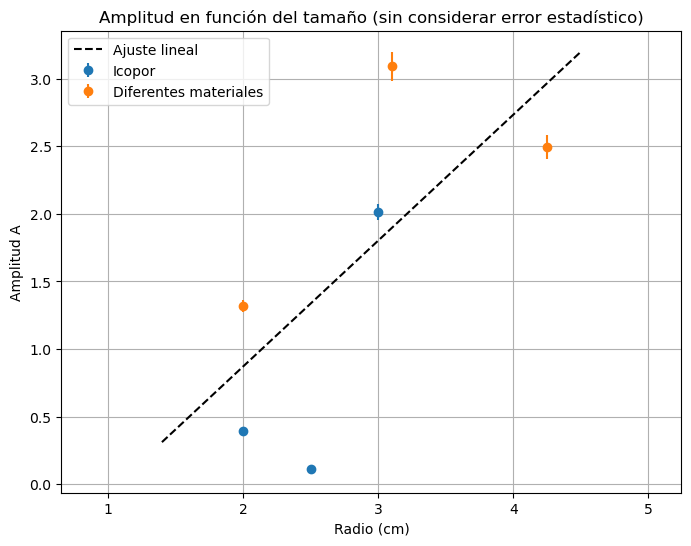

Ajuste:   
0.963 x - 1.134


In [65]:
# Realizamos el mismo análisis para las amplitudes de las oscilaciones
# Obtenemos las amplitudes de los ajustes de las 3 pelotas de icopor
A_icopor = [popt_icopor_peque[0], popt_icopor_med[0], popt_icopor_grande[0]]
A_icopor = [np.abs(A) for A in A_icopor]
A_icopor_error = [np.sqrt(pcov_icopor_peque[0,0]), np.sqrt(pcov_icopor_med[0,0]), np.sqrt(pcov_icopor_grande[0,0])]

# Obtenemos las amplitudes de los ajustes de las 3 pelotas de diferentes materiales
A = [popt_goma[0], popt_pingpong[0], popt_plastGrand[0]]
A = [np.abs(A) for A in A]
A_error = [np.sqrt(pcov_goma[0,0]), np.sqrt(pcov_pingpong[0,0]), np.sqrt(pcov_plastGrand[0,0])]

# Ajuste lineal
lineal_A = np.polyfit(tam_icopor + tam, A_icopor + A, 1)
lineal_A = np.poly1d(lineal_A)

# Graficamos la amplitud en función del tamaño de todas las pelotas, diferenciando por material con el error
plt.figure(figsize=(8,6))
plt.errorbar(tam_icopor, A_icopor, yerr=A_icopor_error, fmt="o", label="Icopor")
plt.errorbar(tam, A, yerr=A_error, fmt="o", label="Diferentes materiales")
plt.plot(np.linspace(1.4,4.5), lineal_A(np.linspace(1.5,4.5)), "--", color="black", label="Ajuste lineal")
# plt.plot([0,5], [0,5], "--", color="black")
plt.xlabel("Radio (cm)")
plt.ylabel("Amplitud A")
plt.title("Amplitud en función del tamaño (sin considerar error estadístico)")
plt.axis("equal")
plt.legend()
plt.grid()
plt.show()

print("Ajuste: ", lineal_A)

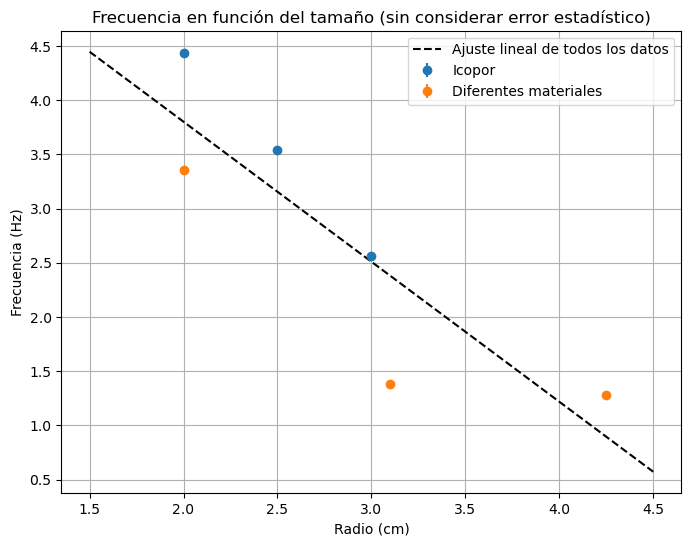

Ajuste: f =  -1.291 r + 6.383


In [62]:
# Finalmente para la frecuencia
# Obtenemos las frecuencias de los ajustes de las 3 pelotas de icopor
w_icopor = [popt_icopor_peque[1], popt_icopor_med[1], popt_icopor_grande[1]]
w_icopor = [w/(2*np.pi) for w in w_icopor]
w_icopor_error = [np.sqrt(pcov_icopor_peque[1,1])/(2*np.pi), np.sqrt(pcov_icopor_med[1,1])/(2*np.pi), np.sqrt(pcov_icopor_grande[1,1])/(2*np.pi)]

# Obtenemos las frecuencias de los ajustes de las 3 pelotas de diferentes materiales
w = [popt_goma[1], popt_pingpong[1], popt_plastGrand[1]]
w = [w/(2*np.pi) for w in w]
w_error = [np.sqrt(pcov_goma[1,1])/(2*np.pi), np.sqrt(pcov_pingpong[1,1])/(2*np.pi), np.sqrt(pcov_plastGrand[1,1])/(2*np.pi)]

# Ajustamos una recta a los datos de frecuencia en función del tamaño de las pelotas 
lineal = np.polyfit(tam_icopor + tam, w_icopor + w, 1)
lineal = np.poly1d(lineal)

# Graficamos la frecuencia en función del tamaño de todas las pelotas, diferenciando por material con el error
plt.figure(figsize=(8,6))
plt.errorbar(tam_icopor, w_icopor, yerr=w_icopor_error, fmt="o", label="Icopor")
plt.errorbar(tam, w, yerr=w_error, fmt="o", label="Diferentes materiales")
plt.plot([1.5,4.5], lineal([1.5,4.5]), "--", color="black", label="Ajuste lineal de todos los datos")
plt.xlabel("Radio (cm)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Frecuencia en función del tamaño (sin considerar error estadístico)")
plt.legend()
plt.grid()
plt.show()

print("Ajuste: f = ", round(lineal[1], 3), "r +", round(lineal[0], 3))
